<a href="https://colab.research.google.com/github/aadityajha/Stock_Predict/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/5
3/3 [==============================] - 4s 50ms/step - loss: 0.2790
Epoch 2/5
3/3 [==============================] - 0s 41ms/step - loss: 0.0870
Epoch 3/5
3/3 [==============================] - 0s 42ms/step - loss: 0.0430
Epoch 4/5
3/3 [==============================] - 0s 41ms/step - loss: 0.0369
Epoch 5/5
2/2 [==============================] - 1s 28ms/step


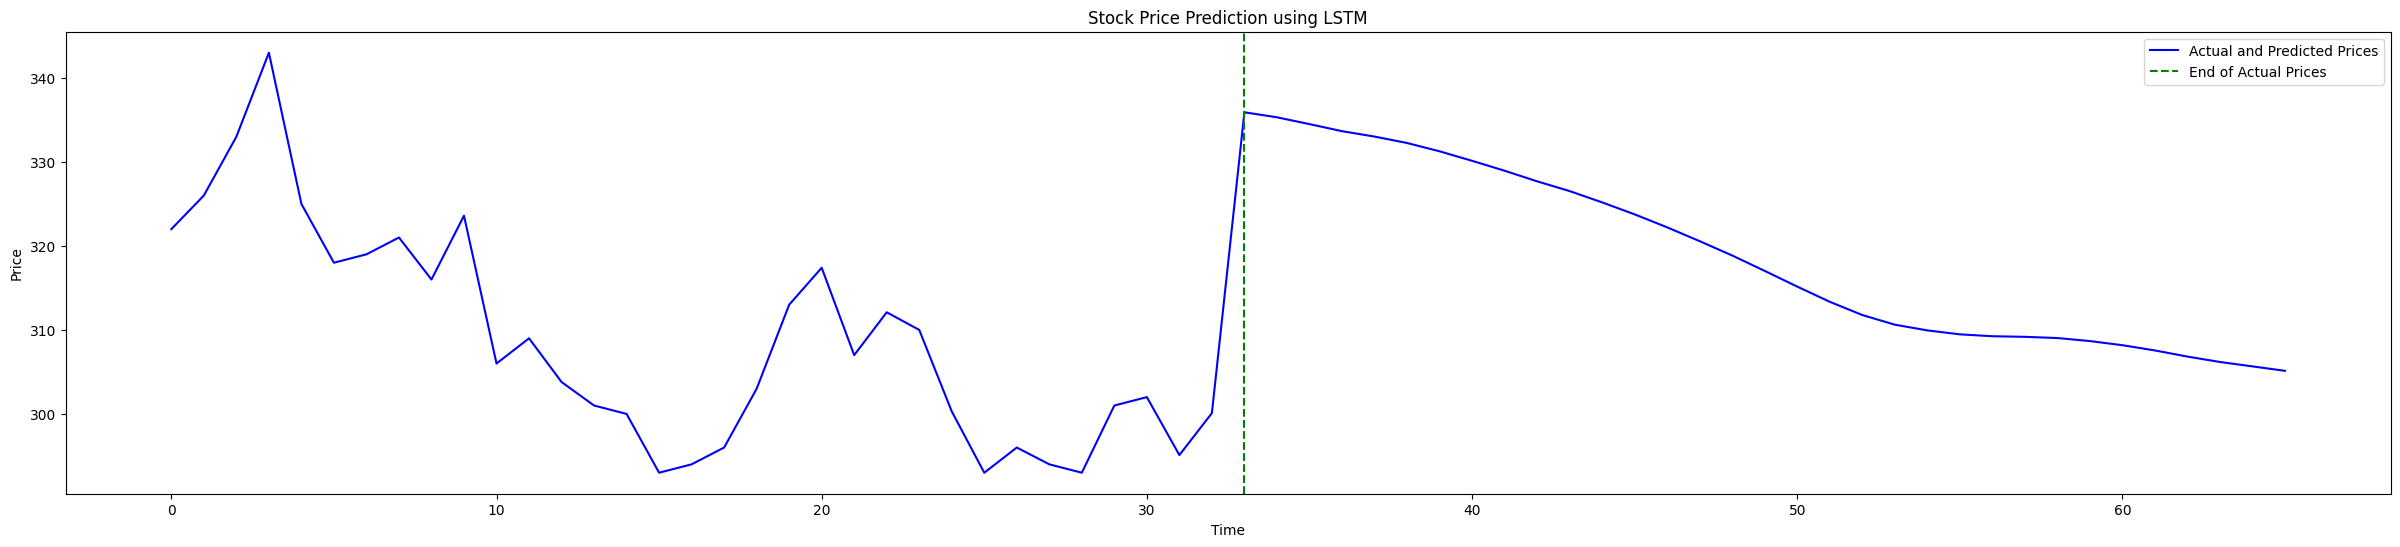

1/1 [==============================] - 0s 50ms/step


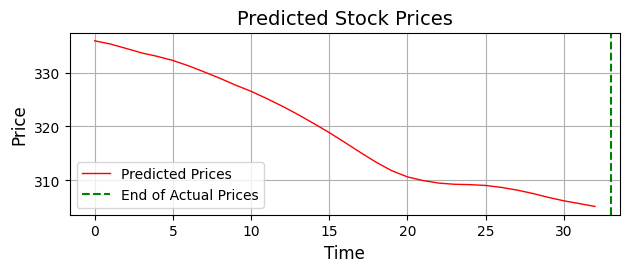

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load your CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bfc.csv')  # Replace 'your_file.csv' with your file name

# Consider 'Close' column for prediction
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Choose sequence length (number of time steps to look back)
sequence_length = 40

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=70))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Predict on the test set
predicted_data = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_data)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Concatenate actual and predicted prices for continuous chart
combined_prices = np.concatenate((actual_prices, predicted_prices), axis=0)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(combined_prices, color='blue', label='Actual and Predicted Prices')
plt.axvline(x=len(actual_prices), color='green', linestyle='--', label='End of Actual Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict future prices
future_predictions = []
last_sequence = scaled_data[-sequence_length:].reshape((1, sequence_length, 1))

for _ in range(30):  # Predict the next 30 days
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = next_pred

# Inverse transform the predicted prices to get actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate date range for the future predictions
last_date = pd.to_datetime(df['Date']).max()
date_range = pd.date_range(start=last_date, periods=30)

# Convert the date range to a list of strings
date_strings = [str(date) for date in date_range]

# Plotting Predicted Prices
plt.subplot(2, 1, 2)
plt.plot(predicted_prices, color='red', label='Predicted Prices', linewidth=1)
plt.axvline(x=len(actual_prices), color='green', linestyle='--', label='End of Actual Prices')
plt.title('Predicted Stock Prices', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()
